In [1]:
import astropy
import astropy.units as u
import astroquery
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from astropy.time import Time 
import os
from astropy.io.votable import parse_single_table
from astropy.time import Time
import pytest
from astropy.table import Table, vstack
import csv
import pandas as pd
from astropy.io.votable import from_table, writeto

In [2]:
def psr_to_gaia_nominal(jname, raj, decj, radius):
    """
        looks for Gaia matches to a single pulsar within a specified radius, and returns the table resulting 
        from the Gaia query with the psr name, ra and dec
    """
    
    # Query Gaia within the range of the given pulsar 
    Gaia.ROW_LIMIT = 2000
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3
    sc = SkyCoord(ra= raj, dec= decj, frame= 'icrs', unit=(u.hourangle, u.deg))
    j = Gaia.cone_search_async(coordinate=sc, radius=u.Quantity(radius, u.arcsec))
    results = j.get_results()

    # use python sort function
    
    if len(results) == 0:
        return results
    else:
        results.add_column(jname, name='Companion Pulsar', index=0)
        results.add_column(raj, name='Pulsar RA', index=1)
        results.add_column(decj, name='Pulsar DEC', index=2)
        return results


In [3]:
def psr_to_gaia(jname, raj, decj,  pmra, pmdec, posepoch, radius):
    """Searches Gaia for possible companion to any given pulsar

    Given input parameters read in from a text file following the guidelines of ATNF parameters, 
    queries Gaia DR2 to find matches (nearby objects from Gaia) based on RA and Dec for each object 
    from the text file to within a certain range, the default being 1 arcmin in both ra and dec.

    Args:
        jname (str): Name of the pulsar being checked for matches 
        raj (str): Right ascension of the pulsar in hh:mm:ss.ss format -- is this actually what it is?
        decj (str): Declination of the pulsar in degrees:mm:ss.ss format -- is this actually what it is?
        pmra (str): Proper motion in ra of the pulsar in string format and mas/yr units
        pmdec (str): proper motion in dec of the pulsar in string format and mas/yr units
        posepoch (str): epoch that the data was taken in string format and mjd units
        height (float): Height of Gaia box search in arcminutes
        width (float): Width of Gaia box search in arcminutes 
        radius (float): Radius of the Gaia cone search in arcminutes
    
    Returns:
        Table: results of the Gaia query in an astropy Table  
    """

    from astropy.time import Time 
    ra = Angle(raj, unit = u.hourangle) # comes in as a string of units hh:mm:ss.ss
    dec = Angle(decj, unit = u.deg) # comes in as a string of units dd:mm:ss.s
    p_pmra = u.Quantity(pmra, u.mas/u.yr) # comes in as a string of units mas/yr
    p_pmdec = u.Quantity(pmdec, u.mas/u.yr) # comes in as a string of units mas/yr
    p_epoch = Time(posepoch, format='mjd').jyear # comes in in units mjd, is immediately converted to jyear tcb

    psr = SkyCoord(ra= raj, dec= decj, unit= (u.hourangle, u.deg), frame = 'icrs', pm_ra_cosdec= p_pmra, pm_dec= p_pmdec)

    # to propogate location of pulsar up to gaia time, must calculate epoch difference
    gaia_epoch = Time('2016.0', format='jyear').jyear
    year_diff = (gaia_epoch.tolist() * u.yr) - (p_epoch.tolist() * u.yr) # difference b/w epochs in years

    # define our new vector of pm times the time diff
    pmtransra = psr.pm_ra_cosdec * year_diff
    pmtransdec = psr.pm_dec * year_diff

    ra_dr3 = psr.ra.to_value(u.mas) * u.mas + (pmtransra)
    dec_dr3 = psr.dec.to_value(u.mas) * u.mas + (pmtransdec)

    # define a new SkyCoord object with the propagated positions
    psr_dr3 = SkyCoord(ra= ra_dr3, dec= dec_dr3, unit= (u.mas, u.mas), frame= 'icrs', pm_ra_cosdec= p_pmra, pm_dec= p_pmdec)

    # Query Gaia within the range of the given pulsar 
    Gaia.ROW_LIMIT = 2000
    Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" # Select early Data Release 3
    #coord=SkyCoord(ra=p_new_ra, dec=p_new_dec, unit=(u.degree, u.degree), frame='icrs')
    j = Gaia.cone_search_async(coordinate=psr_dr3, radius=u.Quantity(radius, u.arcsec))
    results = j.get_results()

    # use python sort function
    
    if len(results) == 0:
        with open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'a') as fd:
            fd.write(jname + ',\n')
            fd.close()
        return results
    else:
        results.add_column(jname, name='Companion Pulsar', index=0)
        results.add_column(raj, name='Pulsar RA', index=1)
        results.add_column(decj, name='Pulsar DEC', index=2)
        results.write('temp.csv', overwrite=True) #writes the results of a single query to a csv file
        f = open('temp.csv', 'r')
        for line in f:
            with open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'a') as fd:
                fd.write(line)
                fd.close()
        return results

In [4]:
def get_matches(input_file, radius=1.):
    """Takes a list of pulsars and returns a list of those with potential matches.

    Takes as input a text file (.csv file) with index number, name, ra, dec, proper
    motion ra, proper motion dec and posepoch of a list of pulsars and produces all of the gaia 
    matches of ra and dec to within a certain range.

    Args: 
        input_file (str): Name of the text file (csv) containing each pulsar with the parameters 'index', 'jname', 
            'ra', 'dec', 'pmra', 'pmdec', 'posepoch' row by row for each object.
        output_file (str): Name of the text file which the pulsar-gaia matches will be output to. If desired,
            specify the full path to which the file should be saved, otherwise it will just be saved to the 
            present working directory
        height (:obj:'float', optional): Height of the rectangle Gaia will query in.
        width (:obj:'float', optional): Width of the rectangle Gaia will query in.
        radius (:obj:'float', optional): Radius of the circle Gaia will query in. 


    """
    from astropy.table import Table, vstack

    f = open(input_file, "r")
    results = Table()
    first_time = True
    skipped = 0

    # Loop through file of ATNF data and combine tables of Gaia matches into one supertable
    for line in f:

      # Parse input
      values = line.split(';')

      if values[3] == '*' or values[4] == '*' or values[6] == '*' or values[7] == '*' or values[9] == '*' or values[10] == '*' or values[12] == '*' or values[13] == '*' or values[15] == '*':
        skipped += 1
        with open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'a') as fd:
          fd.write(values[1] + ',\n')
          fd.close()
        continue

      # write a condition that will perform the query if that pulsar is not in the table, and will skip if it is
      query = True
      g = open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'r')
      for line in g:
        name = line.split(',')
        if name[0] == values[1]:
          query = False
          break
      
      if query:
        # Add result to supertable
        #psr_to_gaia(jname, raj, decj,  pmra, pmdec, posepoch, radius)
        search_result = psr_to_gaia(values[1],values[3],values[6],values[9],values[12],values[15],radius)
        if (len(search_result) == 0):
          continue
        if first_time:
          results = search_result
          first_time = False
        else:  
          results = vstack([results, search_result])

    hits = len(results)
    # results.write(output_file, format='csv', overwrite=True)
    return results, hits, skipped

In [12]:
# create an astropy table of the ATNF data
f = open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/atnf_csv_w_errors.csv', "r")
first_time = True
a1 = []
a3 = []
a4 = []
a6 = []
a7 = []
a9 = []
a10 = []
a12 = []
a13 = []
a15 = []

for line in f:
    values = line.split(';')
    if first_time:
        a1.insert(0, values[1])
        a3.insert(0, values[3])
        a4.insert(0, values[4])
        a6.insert(0, values[6])
        a7.insert(0, values[7])
        a9.insert(0, values[9])
        a10.insert(0, values[10])
        a12.insert(0, values[12])
        a13.insert(0, values[13])
        a15.insert(0, values[15])
        first_time = False
    else:
        a1.append(values[1])
        a3.append(values[3])
        a4.append(values[4])
        a6.append(values[6])
        a7.append(values[7])
        a9.append(values[9])
        a10.append(values[10])
        a12.append(values[12])
        a13.append(values[13])
        a15.append(values[15])

atnf_psrs = Table([a1,a3,a4,a6,a7,a9,a10,a12,a13,a15], names= ['psr', 'ra', 'ra_err', 'dec', 'dec_err', 'pmra', 
                                                               'pmra_err', 'pmdec', 'pmdec_err', 'epoch'])
atnf_psrs

psr,ra,ra_err,dec,dec_err,pmra,pmra_err,pmdec,pmdec_err,epoch
str12,str16,str7,str16,str7,str8,str7,str8,str7,str10
J0002+6216,00:02:58.17,2.0e-02,+62:16:09.4,1.0e-01,*,0,*,0,55806
J0006+1834,00:06:04.8,2.0e-01,+18:34:59,4.0e+00,*,0,*,0,49079.50
J0007+7303,00:07:01.7,2.0e-01,+73:03:07.4,8.0e-01,*,0,*,0,54952.00
J0011+08,00:11:34,1.1e+02,+08:10,8.0e+00,*,0,*,0,57022.00
J0014+4746,00:14:17.75,4.0e-02,+47:46:33.4,3.0e-01,19.3,1.8e+00,-19.7,1.5e+00,49664.00
J0021-0909,00:21:51.47,3.0e-02,-09:09:58.7,1.1e+00,*,0,*,0,58388.00
J0023+0923,00:23:16.877498,7.0e-06,+09:23:23.8604,2.3e-04,-12.44,7.0e-02,-6.16,1.6e-01,56845.00
J0024-7204aa,00:24:05.67,0,-72:04:52.62,0,5.252,2.1e-02,-2.551,2.1e-02,57022.00
J0024-7204ab,00:24:08.1615,5.0e-04,-72:04:47.602,2.0e-03,5.252,2.1e-02,-2.551,2.1e-02,51600


In [14]:
Gaia.login()
Gaia.upload_table(upload_resource=atnf_psrs, table_name="atnf_allpsrs_new5", verbose=True)
Gaia.update_user_table(table_name="atnf_allpsrs_new5",
                       list_of_changes=[["ra", "flags", "Ra"], 
                                        ["dec", "flags", "Dec"]], verbose=True)

# a=[1,2,3]
# b=['a','b','c']
# table = Table([a,b], names=['col1','col2'], meta={'meta':'first table'})
# # Upload
# Gaia.login()
# Gaia.upload_table(upload_resource=table, table_name='table_test_from_astropy')
# Gaia.update_user_table(table_name="table_test_from_astropy",
#                        list_of_changes=[["col1", "flags", "Ra"], 
#                                         ["col2", "flags", "Dec"]])

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Sending pytable.
200 200
[('Date', 'Thu, 02 Mar 2023 19:23:41 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Transfer-Encoding', 'chunked'), ('Content-Type', 'text/plain;charset=ISO-8859-1')]
Uploaded table 'atnf_allpsrs_new5'.
Retrieving table 'atnf_allpsrs_new5'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/tables?tables=atnf_allpsrs_new5
500 500
ERROR: 500: 500
500 Error 500:
esavo.tap.TAPException: java.lang.NullPointerException


HTTPError: Error 500:
esavo.tap.TAPException: java.lang.NullPointerException

In [16]:
Gaia.login()
# table_metadata = Gaia.load_table('atnf_allpsrs_new2')
# table_metadata
Gaia.update_user_table(table_name="atnf_allpsrs_new2",
                       list_of_changes=[["ra", "flags", "Ra"], 
                                        ["dec", "flags", "Dec"]])

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Retrieving table 'atnf_allpsrs_new2'
500 Error 500:
esavo.tap.TAPException: java.lang.NullPointerException


HTTPError: Error 500:
esavo.tap.TAPException: java.lang.NullPointerException

In [50]:
# first step is to run get matches for 10 arcsec
filetouse = '/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/atnf_csv_w_errors.csv'
table, hits, skipped = get_matches(filetouse, radius= 10.)

In [26]:
psr = []
psr_ra = []
psr_dec = []
ra = []
dec = []
hits = 0
psrs_with_hits = 0
skipped = 0
first = True
h = open('/home/annika_deutsch/Binary-Pulsar-Distances/Binary_Pulsar_Distances/matches_10arcsec.csv', 'r')
for line in h:
    values = line.split(',')
    if len(values) < 3: 
        skipped += 1 # skips pulsars that don't have any matches
    else:
        if values[0] == 'Companion Pulsar':
            psrs_with_hits += 1
            continue # skips lines that are just metadata-ish
        else:
            hits += 1
            if first:
                first = False
                psr.insert(0, values[0])
                psr_ra.insert(0, values[1])
                psr_dec.insert(0, values[2])
                ra.insert(0, values[8])
                dec.insert(0, values[10])
            else:
                psr.append(values[0])
                psr_ra.append(values[1])
                psr_dec.append(values[2])
                ra.append(values[8])
                dec.append(values[10])

table = Table([psr, psr_ra, psr_dec, ra, dec], names= ['Pulsar', 'Pulsar RA', 'Pulsar DEC', 'ra', 'dec'])
table

Pulsar,Pulsar RA,Pulsar DEC,ra,dec
str12,str16,str16,str18,str19
J0024-7204aa,00:24:05.67,-72:04:52.62,6.023128743364097,-72.08127489997942
J0024-7204aa,00:24:05.67,-72:04:52.62,6.02136691234547,-72.08178209766417
J0024-7204aa,00:24:05.67,-72:04:52.62,6.02394670980477,-72.0803894414852
J0024-7204aa,00:24:05.67,-72:04:52.62,6.026624481094398,-72.08199713192272
J0024-7204aa,00:24:05.67,-72:04:52.62,6.028650079813069,-72.08034006779617
J0024-7204aa,00:24:05.67,-72:04:52.62,6.029471118493607,-72.08078295262682
J0024-7204aa,00:24:05.67,-72:04:52.62,6.030127420912808,-72.08182771453025
J0024-7204aa,00:24:05.67,-72:04:52.62,6.0263013509831715,-72.07927524167017
J0024-7204aa,00:24:05.67,-72:04:52.62,6.016716693606229,-72.08078388880749


In [28]:
current = 'J0024-7204aa'
psrs_with_hits = [current]
for b in table['Pulsar']:
    if b != current:
        psrs_with_hits.append(b)
        current = b
len(psrs_with_hits)

437

In [29]:
psr_pos = SkyCoord(table['Pulsar RA'], table['Pulsar DEC'], frame = 'icrs', unit =(u.hourangle, u.deg))
source_pos = SkyCoord(table['ra'], table['dec'], frame = 'icrs', unit= (u.deg, u.deg))

source_seps = []
first_time = True
for k in range(len(table)):
    if first_time:
        source_seps.insert(0,psr_pos[k].separation(source_pos[k]))
        first_time = False
    else:
        source_seps.append(psr_pos[k].separation(source_pos[k]))

source_seps[0]

<Angle 0.00015291 deg>

In [33]:
mins = np.zeros(len(psrs_with_hits))
for d in range(len(psrs_with_hits)):
    first_time = True
    for c in range(len(table['Pulsar'])):
        if table['Pulsar'][c] == psrs_with_hits[d]:
            if first_time:
                first_time = False
                minimum = source_seps[c].to_value(u.arcsec)
            else:
                if source_seps[c].to_value(u.arcsec) < minimum:
                    minimum = source_seps[c].to_value(u.arcsec)
    mins[d] = minimum
len(mins)

437

In [35]:
min_dist = Table([psrs_with_hits, mins], names= ['Pulsars with Hits', 'Distance to at least 1 hit'])

Text(0, 0.5, 'Pulsars with Hits / Total Pulsars')

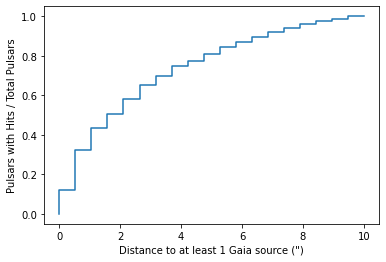

In [45]:
dist_to_one_psr = np.linspace(0,10,20)
n_psr_norm = np.zeros(len(dist_to_one_psr))
for e in range(len(dist_to_one_psr)):
    num = 0
    for f in range(len(min_dist['Distance to at least 1 hit'])):
        if min_dist['Distance to at least 1 hit'][f] < dist_to_one_psr[e]:
            num += 1
    n_psr_norm[e] = num/len(psrs_with_hits)
n_psr_norm

fig = plt.figure
ax = plt.subplot(111)
ax.step(dist_to_one_psr, n_psr_norm, label= 'Pulsars with at least one hit')
ax.set_xlabel('Distance to at least 1 Gaia source (")')
ax.set_ylabel('Pulsars with Hits / Total Pulsars')
#ax.legend()

In [7]:
seps1 = np.linspace(0,10,200)
seps2 = np.linspace(0, 4, 25)

numhits1 = np.zeros(len(seps1)) 
for i in range(len(seps1)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps1[i]:
            num += 1
    numhits1[i] = num

numhits2 = np.zeros(len(seps2)) 
for i in range(len(seps2)):
    num = 0
    for j in range(len(source_seps)):
        if source_seps[j].arcsec <= seps2[i]:
            num += 1
    numhits2[i] = num

numhits2

array([   0.,   16.,   32.,   52.,   73.,  139.,  165.,  211.,  284.,
        403.,  453.,  560.,  667.,  739.,  806.,  886., 1067., 1211.,
       1300., 1472., 1607., 1812., 2033., 2165., 2393.])

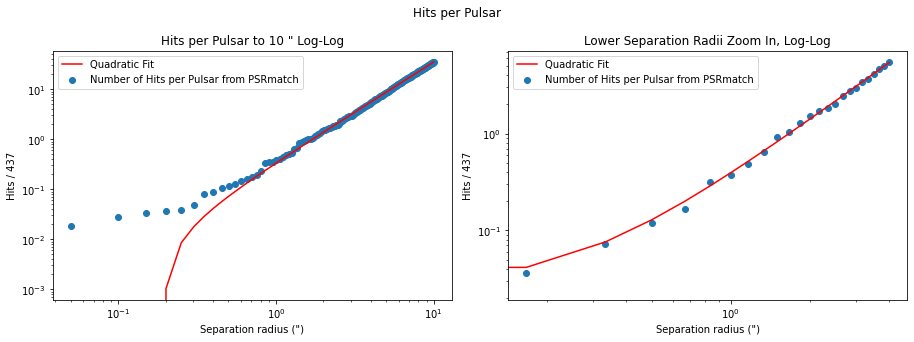

In [10]:
hits_per_pulsar1 = numhits1/(psrs_with_hits)
hits_per_pulsar2 = numhits2/(psrs_with_hits)
a1, b1, c1 = np.polyfit(seps1, hits_per_pulsar1, 2)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(12.8, 4.8))
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122)
# ax3 = plt.subplot(121)
# ax4 = plt.subplot(122)
ax5 = plt.subplot(121)
ax6 = plt.subplot(122)

# # log linear
# ax1.set_yscale('log')
# ax1.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
# ax1.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax1.set_xlabel('Separation radius (")')
# ax1.set_ylabel('Hits / 437')
# ax1.set_title('Hits per Pulsar to 10 " Log-Linear')
# ax1.legend()

# ax2.set_yscale('log')
# ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
# ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax2.set_xlabel('Separation radius (")')
# ax2.set_ylabel('Hits / 437')
# ax2.set_title('Lower Separation Radii Zoom In, Log-Linear')
# ax2.legend()

# #linear 
# ax3.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
# ax3.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
# ax3.set_xlabel('Separation radius (")')
# ax3.set_ylabel('Hits / 437')
# ax3.set_title('Hits per Pulsar to 10 " Linear')
# ax3.legend()

# ax4.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
# ax4.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
# ax4.set_xlabel('Separation radius (")')
# ax4.set_ylabel('Hits / 437')
# ax4.set_title('Lower Separation Radii Zoom In, Linear')
# ax4.legend()

#log-log
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.scatter(seps1, hits_per_pulsar1, label= 'Number of Hits per Pulsar from PSRmatch')
ax5.plot(seps1, quadratic1(a1,b1,c1), label= 'Quadratic Fit', c= 'r')
ax5.set_xlabel('Separation radius (")')
ax5.set_ylabel('Hits / 437')
ax5.set_title('Hits per Pulsar to 10 " Log-Log')
ax5.legend()

ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax6.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
ax6.set_xlabel('Separation radius (")')
ax6.set_ylabel('Hits / 437')
ax6.set_title('Lower Separation Radii Zoom In, Log-Log')
ax6.legend()

fig.suptitle('Hits per Pulsar')
fig.tight_layout()

In [25]:
dist_to_one_psr = np.linspace(0,1,30)
n_psr = np.zeros(len(dist_to_one_psr))
for i in range(len(dist_to_one_psr)):
    first_one = True
    psrs = []
    for j in range(len(source_seps)):
        if source_seps[j].value < dist_to_one_psr[i]:
            if first_one:
                psrs.insert(0,table['Pulsar'][j])
                first_one = False
            else:
                add = True
                for k in range(len(psrs)):
                    if table['Pulsar'][j] == psrs[k]:
                        add = False
                if add:
                    psrs.append(table['Pulsar'][j])
    n_psr[i] = len(psrs)
n_psr

array([  0., 437., 437., 437., 437., 437., 437., 437., 437., 437., 437.,
       437., 437., 437., 437., 437., 437., 437., 437., 437., 437., 437.,
       437., 437., 437., 437., 437., 437., 437., 437.])

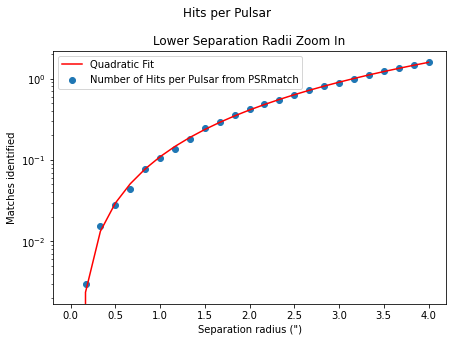

In [5]:
zoomed_hits_per_psr = np.array([   0.,   10.,   51.,   94.,  149.,  257.,  349.,  460.,  606.,
        823.,  986., 1198., 1409., 1618., 1830., 2110., 2432., 2714.,
       2969., 3273., 3646., 4080., 4497., 4833., 5314.])

seps2 = np.linspace(0, 4, 25)

hits_per_pulsar2 = zoomed_hits_per_psr/(3342)
a2, b2, c2 = np.polyfit(seps2, hits_per_pulsar2, 2)

# google how to get chisquared 

def quadratic1(a,b,c):
    return a* (seps1**2) + b*(seps1) + c

def quadratic2(a,b,c):
    return a* (seps2**2) + b*(seps2) + c

fig = plt.figure(figsize=(6.4, 4.8))
ax2 = plt.subplot()

ax2.set_yscale('log')
ax2.scatter(seps2, hits_per_pulsar2, label= 'Number of Hits per Pulsar from PSRmatch')
ax2.plot(seps2, quadratic2(a2,b2,c2), label= 'Quadratic Fit', c= 'r')
ax2.set_xlabel('Separation radius (")')
ax2.set_ylabel('Matches identified')
ax2.set_title('Lower Separation Radii Zoom In')
ax2.legend()

fig.suptitle('Hits per Pulsar')
fig.tight_layout()